In [1]:
import os
import glob
import tqdm
import torch
import numpy as np
import omegaconf
from mllib.src.train import main

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt

import torch.cuda
from mllib.src.evaluate import evaluate
from mllib.src.utils import prepare_device, load_yaml

/home/daniel0413/.conda/envs/torch_171_daniel/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/daniel0413/.conda/envs/torch_171_daniel/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
# config = './result/model/conv-tasnet/20230220-100114/config.yaml'
config = './result/model/conv-tasnet/20230221-231507/config.yaml'
# config = './result/model/conv-tasnet/20230223-140053/config.yaml'

In [3]:
solver = main(obj_config=config, return_solver=True)

------------------------------
	Search training datasets...
	 Sample file: /home/olive-samba/sambashare/data/Sound/clarity_ICASSP2023/clarity_CEC2_data/clarity_data/train/scenes/S00767_mix_CH0.wav
	 Offset: 0
	 Limit: None
	 Final length: 23760
	 Norm:  z-score
	 Sample rate:  16000
	 Mode: se
	 Sample file: /home/olive-samba/sambashare/data/Sound/clarity_ICASSP2023/clarity_CEC2_data/clarity_data/train/scenes/S00045_mix_CH1.wav
	 Offset: 0
	 Limit: None
	 Final length: 60
	 Norm:  z-score
	 Sample rate:  16000
	 Mode: se
Train 20196, Validation 3564, Test 60
------------------------------
	Loading data loader...
	The number of CPU:  20
------------------------------
	Loading Model...
ConvTasNet(
  (encoder): Encoder(
    (conv1d_U): Conv1d(2, 512, kernel_size=(32,), stride=(16,), bias=False)
  )
  (separator): TemporalConvNet(
    (network): Sequential(
      (0): ChannelwiseLayerNorm()
      (1): Conv1d(512, 128, kernel_size=(1,), stride=(1,), bias=False)
      (2): Sequential(
      

In [4]:
model = solver.model

In [5]:
args = load_yaml(config)
n_gpu = torch.cuda.device_count()
device = prepare_device(n_gpu, cudnn_deterministic=args.solver.cudnn_deterministic)

Using CuDNN deterministic mode in the experiment.


In [6]:
device = torch.device("cpu")
model = model.to(device)

In [7]:
args.dset.name = "Clarity"
# args.dset.name = "VoiceBankDEMAND"

if args.dset.name == "VoiceBankDEMAND":
    log_voicebank = "./data/VoiceBankDEMAND/DS_10283_2791/logfiles"
    text_files = glob.glob(
        os.path.join(log_voicebank, "*trainset*")
    )
    print(text_files)
    metadata = []
    for text_file in text_files:
        with open(text_file, "r") as tmp:
            text = tmp.read().split("\n")
            for i, t in enumerate(text):
                text[i] = t.split(" ")
        
            metadata.append(text)
    print(metadata[0][0])

elif args.dset.name == "Clarity":
    log_clarity = "./mllib/data/metadata/scenes.train.snr.json"
    metadata = omegaconf.OmegaConf.load(log_clarity)
    print(list(metadata.values())[0], list(metadata.keys())[0])

1.1382 S00001


In [8]:
from mllib.src.distrib import get_train_wav_dataset

SNR = '0' # '0', '5', '10', '15' # SNR = P_{Signal} / P_{Noise}

test_dataset = None

if args.dset.name == "VoiceBankDEMAND":
    args.dset.wav = './data/VoiceBankDEMAND/DS_10283_2791'
    train_dataset, validation_dataset, test_dataset = get_train_wav_dataset(config=args.dset)

elif args.dset.name == "Clarity":
    # # TODO: Always set the root for dataset files
    # args.dset.wav = ''
    args.default.config = './recipes/icassp_2023/MLbaseline/config_train.yaml'
    train_dataset, validation_dataset, test_dataset = get_train_wav_dataset(config=args.dset)

dataset = test_dataset

flag_find = False
data_test = None

if args.dset.name == "VoiceBankDEMAND":
    for data in tqdm.tqdm(dataset, ncols=120):
        mixture, sources, origial_length, name = data
        for imetadata in range(len(metadata)):
            for ifile in range(len(metadata[imetadata])):
                if metadata[imetadata][ifile][0] == name:
                    if metadata[imetadata][ifile][-1] == SNR:
                        flag_find = True
                    else:
                        break
        if flag_find:
            data_test = data
            break

elif args.dset.name == "Clarity":
    # data_test = dataset[0]
    # mixture, clean, origial_length, name = data_test
    # scene_name = name.split("_")[0]
    # SNR = metadata[scene_name]
    # print("Clarity dataset SNR: ", SNR)

    SNR = int(SNR)
    for data in tqdm.tqdm(dataset, ncols=120):
        mixture, sources, origial_length, name = data
        scene_name = name.split("_")[0]
        if metadata[scene_name] > SNR and metadata[scene_name] < SNR+5:
            data_test = data
            SNR = metadata[scene_name]
            break
    
    print("Clarity dataset SNR: ", SNR)

# data_test

	 Sample file: /home/olive-samba/sambashare/data/Sound/clarity_ICASSP2023/clarity_CEC2_data/clarity_data/train/scenes/S01399_mix_CH3.wav
	 Offset: 0
	 Limit: None
	 Final length: 23760
	 Norm:  z-score
	 Sample rate:  16000
	 Mode: se
	 Sample file: /home/olive-samba/sambashare/data/Sound/clarity_ICASSP2023/clarity_CEC2_data/clarity_data/train/scenes/S00294_mix_CH1.wav
	 Offset: 0
	 Limit: None
	 Final length: 60
	 Norm:  z-score
	 Sample rate:  16000
	 Mode: se
Train 20196, Validation 3564, Test 60


  8%|███████                                                                             | 5/60 [00:01<00:13,  4.02it/s]

Clarity dataset SNR:  4.2729


In [9]:
from mllib.src.model.types import (MULTI_SPEECH_SEPERATION_MODELS,
                MULTI_CHANNEL_SEPERATION_MODELS,
                MONARCH_SPEECH_SEPARTAION_MODELS, 
                STFT_MODELS,
                WAV_MODELS,)
mixture, sources, origial_length, name = data_test

nchannel, nsample = mixture.shape
num_spk = sources.shape[0]

# mono channel to stereo for source separation models
assert args.model.audio_channels == nchannel, f"Channel between {args.dset.name} and {args.model.name} did not match..."
assert args.model.num_spk == num_spk, f"number of speakers between {args.dset.name} and {args.model.name} did not match..."

if args.model.name in MULTI_SPEECH_SEPERATION_MODELS:
    assert num_spk == len(args.model.sources), f"number of speakers between {args.dset.name} and {args.model.name} did not match..."

# if not source separation models, merge batch and channels
if args.model.name in MONARCH_SPEECH_SEPARTAION_MODELS:
    mixture = torch.reshape(mixture, shape=(nchannel, 1, nsample))


In [10]:
mixture.shape, args.model.name, name

(torch.Size([2, 92170]), 'conv-tasnet', 'S03488_target_CH1')

In [11]:
enhanced = evaluate(mixture=mixture[None], model=model, device=device, config=args)
enhanced = torch.squeeze(enhanced, dim=0)

In [12]:
enhanced.shape, sources.shape, args.model.name, name

(torch.Size([2, 2, 92170]),
 torch.Size([2, 2, 92170]),
 'conv-tasnet',
 'S03488_target_CH1')

In [26]:
enhanced = enhanced.detach().cpu()
sources = sources.detach().cpu()

if args.model.name in MULTI_SPEECH_SEPERATION_MODELS:
    enhanced_target = enhanced[0, ...]
    sources_target = sources[0, ...]

In [27]:
enhanced_target.shape, sources_target.shape, mixture.shape

(torch.Size([2, 92170]), torch.Size([2, 92170]), torch.Size([2, 92170]))

In [28]:
enhanced_np = enhanced_target
mixture_np = mixture
sources_np = sources_target

In [29]:
enhanced_np = enhanced_np.flatten().numpy()
mixture_np = mixture_np.flatten().numpy()
sources_np = sources_np.flatten().numpy()

In [30]:
enhanced_np.shape, mixture_np.shape, sources_np.shape

((184340,), (184340,), (184340,))

Text(0.5, 1.0, 'Enhanced')

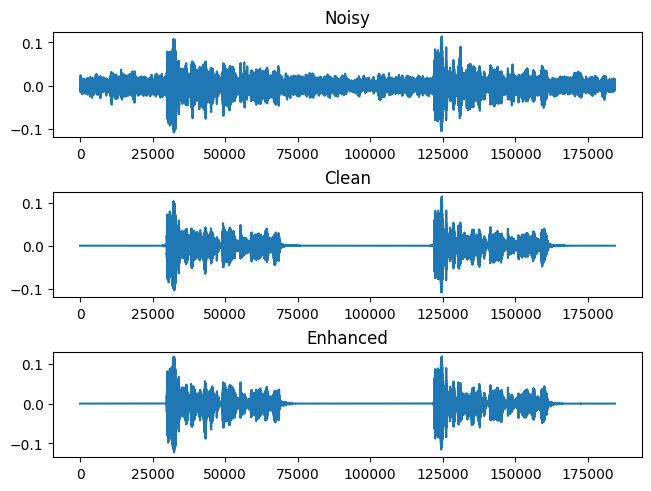

In [31]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, constrained_layout=True)

ax0.plot(mixture_np)
ax0.set_title("Noisy")
ax1.plot(sources_np)
ax1.set_title("Clean")
ax2.plot(enhanced_np)
ax2.set_title("Enhanced")


(0.11834763, 0.1142836)

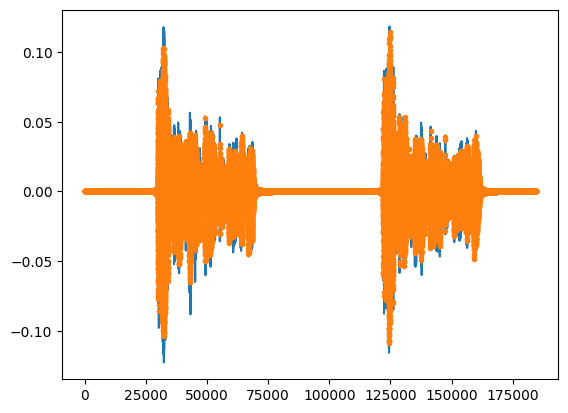

In [32]:
plt.plot(enhanced_np)
plt.plot(sources_np, ".")
enhanced_np.max(), sources_np.max()

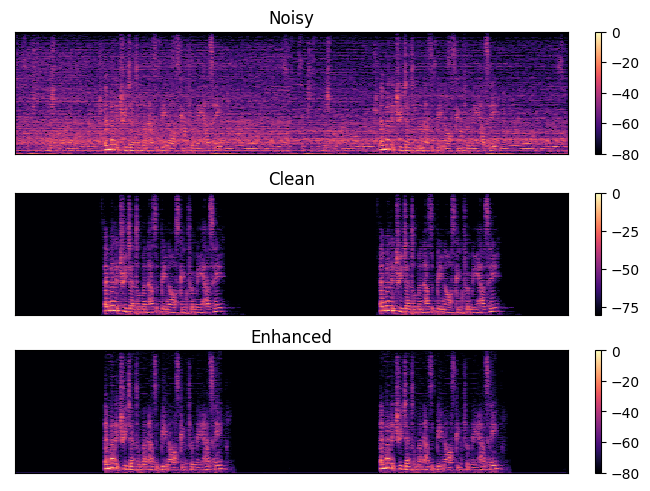

In [33]:
fig, (ax0, ax1, ax2,) = plt.subplots(nrows=3, sharey=True, constrained_layout=True)

def show_stft(y, _fig, _ax, name):
    D = librosa.stft(y)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, ax=_ax)
    _ax.set_title(name)
    _fig.colorbar(img, ax=_ax)
    

show_stft(mixture_np, fig, ax0, "Noisy")
show_stft(sources_np, fig, ax1, "Clean")
show_stft(enhanced_np, fig, ax2, "Enhanced")

In [34]:
ipd.Audio(mixture_np, rate=args.dset.sample_rate)

In [35]:
ipd.Audio(sources_np, rate=args.dset.sample_rate)

In [36]:
ipd.Audio(enhanced_np, rate=args.dset.sample_rate)

In [ ]:
import soundfile as sf
sf.write(file="./sources.wav", data=sources_np, samplerate=args.dset.sample_rate)
sf.write(file="./mixture.wav", data=mixture_np, samplerate=args.dset.sample_rate)
sf.write(file="./enhanced.wav", data=enhanced_np, samplerate=args.dset.sample_rate)

In [24]:
from mllib.src.metric import SI_SDR, STOI, WB_PESQ

In [25]:
metrics = [SI_SDR, STOI, WB_PESQ]

sources_score = np.expand_dims(np.expand_dims(sources_np, 0), 0)
mixture_score = np.expand_dims(np.expand_dims(mixture_np, 0), 0)
enhanced_score = np.expand_dims(np.expand_dims(enhanced_np, 0), 0)

# sources_score = np.expand_dims(np.expand_dims(sources_np[..., :sources_np.shape[0]//2], 0), 0)
# mixture_score = np.expand_dims(np.expand_dims(mixture_np[..., :sources_np.shape[0]//2], 0), 0)
# enhanced_score = np.expand_dims(np.expand_dims(enhanced_np[..., :sources_np.shape[0]//2], 0), 0)

print(sources_score.shape, mixture_score.shape, enhanced_score.shape)

for metric in metrics:
    print("Mixture", metric, metric(sources_score, mixture_score, sr=args.dset.sample_rate))
    print("Enhanced", metric, metric(sources_score, enhanced_score, sr=args.dset.sample_rate))

(1, 1, 184340) (1, 1, 184340) (1, 1, 184340)
Mixture <function SI_SDR at 0x7f331eff2f70> 3.796497881412506
Enhanced <function SI_SDR at 0x7f331eff2f70> -23.811419010162354
Mixture <function STOI at 0x7f331eff4040> 0.8313115262429377
Enhanced <function STOI at 0x7f331eff4040> 0.1061518881110816
Mixture <function WB_PESQ at 0x7f331eff40d0> 0
Enhanced <function WB_PESQ at 0x7f331eff40d0> 0
